# GCN Clustering Analysis

GCN Clustering clusters the graph into M subgraphs and uses those as mini-batches to speed up training. One problem is that might ignore between-cluster links which might affect the message passing of a GCN. The current method of random sampling q clusters to create a batch might not be too effective in catching between-cluster links if there is a low probability of the batch containing them. Below I do an analysis pretending each node in the graph is a cluster

In [1]:
import numpy as np
import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import coo_matrix

conn = np.load(f'../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

edges = from_scipy_sparse_matrix(A)
edge_list = [(u.item(),v.item(), weight) for u, v, weight in zip(edges[0][0], edges[0][1], edges[1])]
G = nx.Graph()
G.add_weighted_edges_from(edge_list)
G.remove_edges_from(nx.selfloop_edges(G))
# nx.draw(G, with_labels=True, font_weight='bold')

NameError: name 'nx' is not defined

In [307]:
def num_between_links(G, groups):
    num_between_links_list = []
    
    for group in groups:
        num_between_links = 0
        for i in range(len(group)):
            for j in range(i+1, len(group)):
                if G.has_edge(group[i], group[j]):
                    num_between_links += 1
        num_between_links_list.append(num_between_links)
    
    return num_between_links_list

def sample_groups(G, q, rw=False):
    nodes = list(G.nodes())
    groups = []
    while len(nodes) > 0:
        if len(nodes) < q:
            group = nodes
        else:
            if rw:
                group = random_walk(nodes, q)
            else:
                group = np.random.choice(nodes, q, replace=False)
        nodes = [n for n in nodes if n not in group]
        groups.append(group)
    return groups

def random_walk(nodes, q):
    # Start at a random node
    node = np.random.choice(list(nodes))
    subgraph = G.subgraph(nodes)
    walk = [node]

    # Perform the random walk
    for _ in range(q - 1):
        neighbors = [n for n in subgraph.neighbors(node) if n not in walk]
        if neighbors:
            node = np.random.choice(neighbors)
            walk.append(node)
        else:
            break

    return walk

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

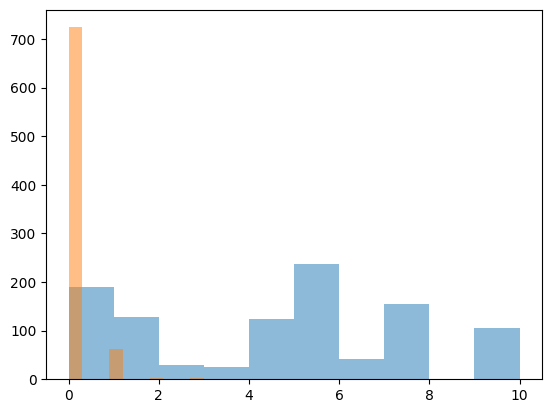

In [312]:
# Generate data for rw=True
between_link_data_true = [num_between_links(G, sample_groups(G, 5, rw=True)) for _ in range(1)]
between_link_data_true = [item for sublist in between_link_data_true for item in sublist]

# Generate data for rw=False
between_link_data_false = [num_between_links(G, sample_groups(G, 5, rw=False)) for _ in range(1)]
between_link_data_false = [item for sublist in between_link_data_false for item in sublist]

# Plot on the i-th subplot
plt.hist(between_link_data_true, alpha=0.5, label='rw=True')
plt.hist(between_link_data_false, alpha=0.5, label='rw=False')

plt.set_title(f'Histogram for q={5}')  # Set the title of the i-th subplot
plt.legend()  # Add a legend to the i-th subplot

plt.show()

As we can see for reasonably sized q, the number of between links we actually see within a batch is skewed right. This means that even though we try aggregating different clusters together into a batch so we can capture between cluster edges, the number of times we see these relationship is low.

I try increasing the probability by using random walk sampling treating the clusters as part of their own graph rather than simply random sampling

In [314]:
from load import load_data

data = load_data(1)

In [320]:
connectivity_data = np.load('../data/xbar/1/xbar_connectivity.npz')

In [329]:
set(connectivity_data['data'])

{1, 2, 3, 4, 5, 6}

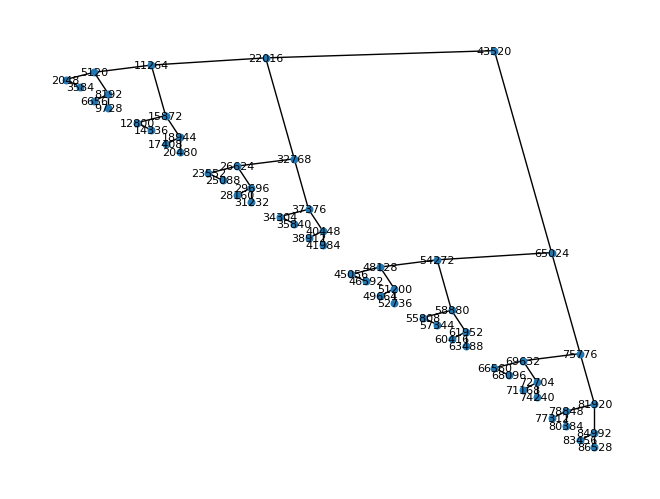

In [340]:
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

def print_bst(bst, indent=0):
    value, left, right = bst
    print(' ' * indent + str(value))
    if isinstance(left, tuple):
        print_bst(left, indent + 2)
    else:
        print(' ' * (indent + 2) + str(left))
    if isinstance(right, tuple):
        print_bst(right, indent + 2)
    else:
        print(' ' * (indent + 2) + str(right))


congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])

def draw_bst(bst, parent=None, pos={}, x=0, y=0, dx=1, dy=1):
    value, left, right = bst
    pos[value] = (x, y)
    G.add_node(value)
    if parent is not None:
        G.add_edge(parent, value)
    if isinstance(left, tuple):
        pos, x, y = draw_bst(left, value, pos, x-dx, y-dy, dx/2, dy)
    if isinstance(right, tuple):
        pos, x, y = draw_bst(right, value, pos, x+dx, y-dy, dx/2, dy)
    return pos, x, y

G = nx.DiGraph()
pos, _, _ = draw_bst(xbst)
nx.draw(G, pos, with_labels=True, arrows=False, node_size=22, font_size=8)
plt.show()

In [362]:
with gzip.open(f'../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])

def getGRCIndex(x,y,xbst,ybst):
            while (type(xbst)==tuple):
                if x < xbst[0]:
                    xbst=xbst[1]
                else:
                    xbst=xbst[2]
                    
            while (type(ybst)==tuple):
                if y < ybst[0]:
                    ybst=ybst[1]
                else:
                    ybst=ybst[2]
                    
            return ybst, xbst

demand = np.zeros(shape = [instances.shape[0],])


for k in range(instances.shape[0]):
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
                
instances['routing_demand'] = demand

In [ ]:
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
plt.figure()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('coolwarm')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5, edgecolor='black', linewidth=0.5)
# Display the plot
plt.show()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('hot')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['RuntimeError: Could not locate METIS dll. Please set the METIS_DLL environment variable to its full path.yloc'], color=cmap(normalized_demand), s=5)
# Display the plot
plt.show()

In [381]:
import metis

RuntimeError: Could not locate METIS dll. Please set the METIS_DLL environment variable to its full path.

: 

C:\Users\spenc\AppData\Local\Temp\ipykernel_9404\1212054739.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


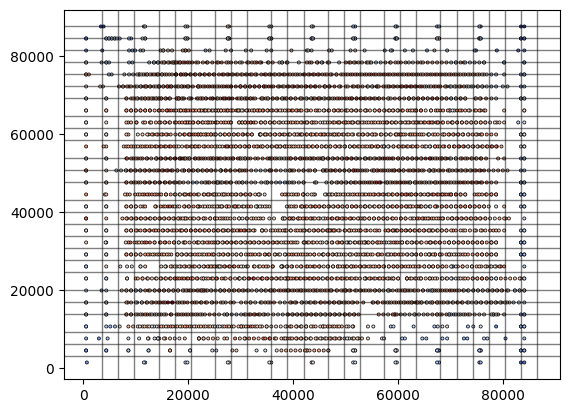

C:\Users\spenc\AppData\Local\Temp\ipykernel_9404\1212054739.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hot')


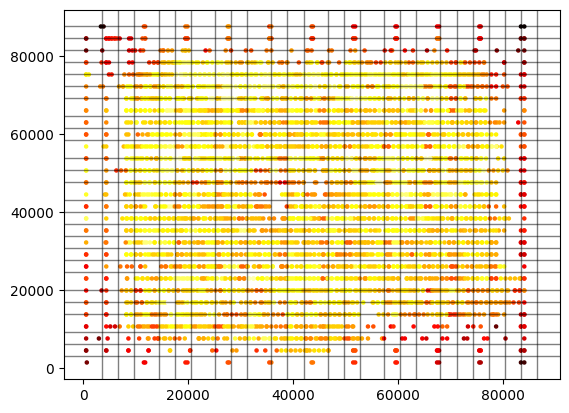

In [ ]:
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
import matplotlib.pyplot as plt

def get_leaf_nodes(bst):
    value, left, right = bst
    if not isinstance(left, tuple) and not isinstance(right, tuple):
        return [value]
    leaves = []
    if isinstance(left, tuple):
        leaves.extend(get_leaf_nodes(left))
    if isinstance(right, tuple):
        leaves.extend(get_leaf_nodes(right))
    return leaves

# Get leaf nodes for x and y BSTs
x_leaf_nodes = get_leaf_nodes(xbst)
y_leaf_nodes = get_leaf_nodes(ybst)

# Create a new figure
plt.figure()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('coolwarm')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5, edgecolor='black', linewidth=0.5)
# Display the plot
plt.show()

import matplotlib.cm as cm

# Normalize the demand values to the range [0, 1]
normalized_demand = (instances['routing_demand'] - instances['routing_demand'].min()) / (instances['routing_demand'].max() - instances['routing_demand'].min())

# Create a new colormap
cmap = cm.get_cmap('hot')

# Draw each x boundary as a vertical line
for x in x_leaf_nodes:
    plt.axvline(x=x, color='black', linewidth=1, alpha=0.5)

# Draw each y boundary as a horizontal line
for y in y_leaf_nodes:
    plt.axhline(y=y, color='black', linewidth=1, alpha=0.5)

# Plot instances with colors based on demand
plt.scatter(instances['xloc'], instances['yloc'], color=cmap(normalized_demand), s=5)
# Display the plot
plt.show()